In [1]:
import numpy as np
import pandas as pd
import open3d
import os
import tqdm
import matplotlib.pyplot as plt
import utils.helpers as helpers
import utils.fread as fread
import utils.registration as registration
import scipy

from sklearn.decomposition import PCA

from utils.depth_camera import DepthCamera

In [41]:
data_dir = "data/raw_data"
experiment = "exp_8"
trial = "trial_2"
subject = "subject-1"
sequence = 2

file_name = f"{experiment}__{trial}__{subject}__{sequence:02d}"
pose_file = os.path.join("data/trajectories/groundtruth", experiment, f"{file_name}.pose.npz")

motion_dir = os.path.join(data_dir, experiment, trial, subject, f"{sequence:02d}", "motion")

In [56]:
accel_df = pd.read_csv(os.path.join(motion_dir, "accel.csv"))
gyro_df = pd.read_csv(os.path.join(motion_dir, "gyro.csv"))

accel_df.drop_duplicates("timestamp", inplace=True)
gyro_df.drop_duplicates("timestamp", inplace=True)

gravity_df = pd.DataFrame(columns=["timestamp", "x", "y", "z"])

imu_df = pd.merge(accel_df, gyro_df, on="timestamp", suffixes=("a", "g"))

raw_accel_df = imu_df[["timestamp", "xa", "ya", "za"]].copy()

frame_rate = accel_df.shape[0] / (accel_df.timestamp.values[-1] - accel_df.timestamp.values[0]) * 1000
print(f"Frame rate: {frame_rate:.2f} Hz")

Frame rate: 400.91 Hz


### Low-pass filter

In [4]:
# Low pass filter
alpha = 0.8
gravity = [0, 0, 0]
# only for analysis
gravity_df = pd.DataFrame(columns=["timestamp", "x", "y", "z"])

for i in tqdm.trange(imu_df.shape[0]):
    for j in range(3):
        gravity[j] = alpha * gravity[j] + (1 - alpha) * imu_df.iloc[i, 1 + j]
        imu_df.iloc[i, 1 + j] = imu_df.iloc[i, 1 + j] - gravity[j]
    
    gravity_df = pd.concat([gravity_df, pd.DataFrame({"timestamp": [imu_df.iloc[i, 0]], "x": [gravity[0]], "y": [gravity[1]], "z": [gravity[2]]})], ignore_index=True)

100%|██████████| 8019/8019 [00:06<00:00, 1254.43it/s]


<AxesSubplot:title={'center':'Gravity'}, xlabel='Timestamp', ylabel='Acceleration (m/s^2)'>

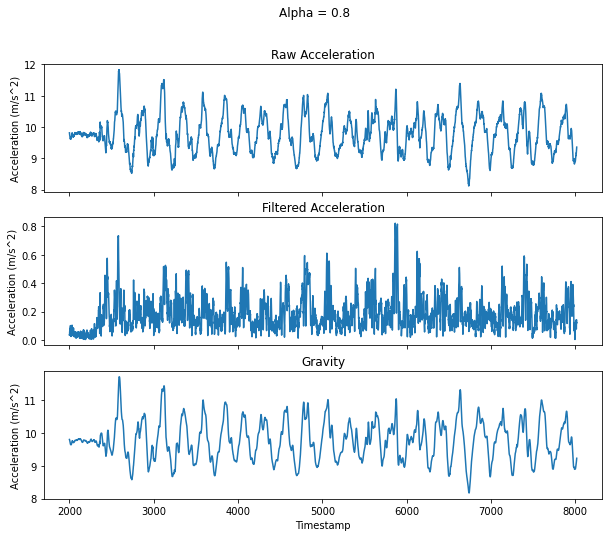

In [8]:
figure, axes = plt.subplots(3, 1, figsize=(10, 8), sharex=True)
figure.suptitle(f"Alpha = {alpha}")

raw_accel_df.iloc[2000:].apply(lambda x: np.linalg.norm(x[1:4]), axis=1).plot(xlabel="Timestamp", ylabel="Acceleration (m/s^2)", title="Raw Acceleration", ax=axes[0])
imu_df.iloc[2000:].apply(lambda x: np.linalg.norm(x[1:4]), axis=1).plot(xlabel="Timestamp", ylabel="Acceleration (m/s^2)", title="Filtered Acceleration", ax=axes[1])
gravity_df.iloc[2000:].apply(lambda x: np.linalg.norm(x[1:4]), axis=1).plot(xlabel="Timestamp", ylabel="Acceleration (m/s^2)", title="Gravity", ax=axes[2])

<AxesSubplot:title={'center':'Filtered Acceleration'}, xlabel='Time (ms)', ylabel='Acceleration (m/s^2)'>

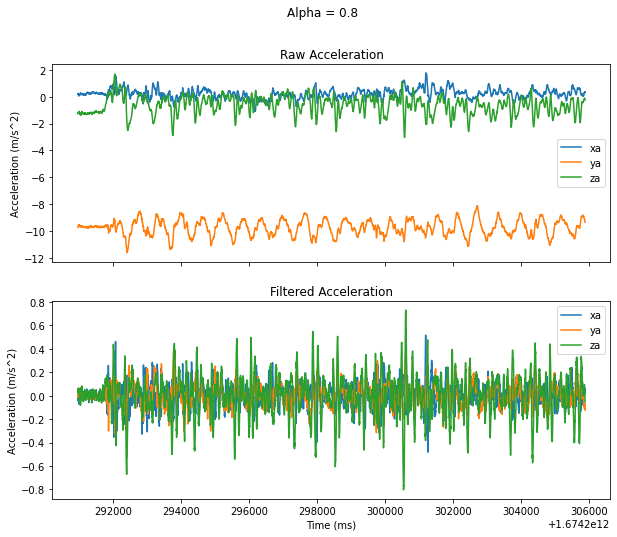

In [9]:
figure, axes = plt.subplots(2, 1, figsize=(10, 8), sharex=True)
figure.suptitle(f"Alpha = {alpha}")
raw_accel_df.iloc[2000:].plot(x="timestamp", y=["xa", "ya", "za"], xlabel="Time (ms)", ylabel="Acceleration (m/s^2)", title="Raw Acceleration", ax=axes[0])
imu_df.iloc[2000:].plot(x="timestamp", y=["xa", "ya", "za"], xlabel="Time (ms)", ylabel="Acceleration (m/s^2)", title="Filtered Acceleration", ax=axes[1])

In [10]:
# remove nan values due to rolling mean
imu_df = imu_df.iloc[2000:]
# compute dt in seconds
imu_df.loc[:, "dt"] = np.concatenate([[0], (imu_df.timestamp.values[1:] - imu_df.timestamp.values[:-1]) / 1000])
# remove first row as the dt is 0
imu_df = imu_df.iloc[1:]
# reset index in pandas data frame
imu_df.reset_index(drop=True, inplace=True)

# Fill 0 for displacement, angles, and coordinates
imu_df.loc[:, "x"] = np.zeros(len(imu_df))
imu_df.loc[:, "y"] = np.zeros(len(imu_df))
imu_df.loc[:, "z"] = np.zeros(len(imu_df))

In [35]:
# calculate displacement and rotation
rotation_matrix = np.identity(4)

velocity = [0, 0, 0]

for i in tqdm.tqdm(range(1, len(imu_df))):
    v = imu_df.iloc[i].values
    dt = v[7]
    # current displacement and rotation
    da = np.degrees([v[j + 4] * dt for j in range(3)])
    dd = [(velocity[j] * dt) + (0.5 * v[j + 1] * dt * dt) for j in range(3)]
    
    d = np.dot(rotation_matrix, np.array([*dd, 1]))
    
    imu_df.iloc[i, 8] = imu_df.iloc[i - 1, 8] + d[0]
    imu_df.iloc[i, 9] = imu_df.iloc[i - 1, 9] + d[1]
    imu_df.iloc[i, 10] = imu_df.iloc[i - 1, 10] + d[2]
    
    rotation_matrix = helpers.rotate_transformation_matrix(rotation_matrix, da[0], da[1], da[2])
    velocity = [velocity[j] + v[j + 1] * dt for j in range(3)]

100%|██████████| 6017/6017 [00:01<00:00, 3499.81it/s]


In [36]:
# create trajectory as a pcd
xyz = imu_df.loc[:, ["x", "y", "z"]].values
pcd = helpers.make_pcd(xyz)
pcd.paint_uniform_color([1, 0, 0])

# load ground truth trajectory
sequence_ts = fread.get_timstamps_from_images(os.path.join(data_dir, experiment, trial, subject, f"{sequence:02d}", "frames"), ext=".depth.png")
start_t = helpers.nearest(sequence_ts, imu_df.timestamp.values[0])
start_index = np.where(sequence_ts == start_t)[0][0]

trajectory_t = np.load(pose_file)["trajectory_t"]
pcd_gt = helpers.make_pcd(trajectory_t[start_index:, :3, 3])
pcd_gt.paint_uniform_color([0, 1, 0])
    
print("IMU Distance: ", np.linalg.norm(xyz[-1] - xyz[0]))
print("GT Distance: ", np.linalg.norm(trajectory_t[-1, :3, 3] - trajectory_t[start_index, :3, 3]))

IMU Distance:  0.08915088989534294
GT Distance:  10.118946802419455


### Moving average filter

In [93]:
win_len = int(frame_rate * 4)

accel_mavg = imu_df[["xa", "ya", "za"]].rolling(window=win_len).mean()
imu_df[["xa", "ya", "za"]] = imu_df[["xa", "ya", "za"]] - accel_mavg

<AxesSubplot:title={'center':'Gravity'}, xlabel='Time (ms)', ylabel='Acceleration (m/s^2)'>

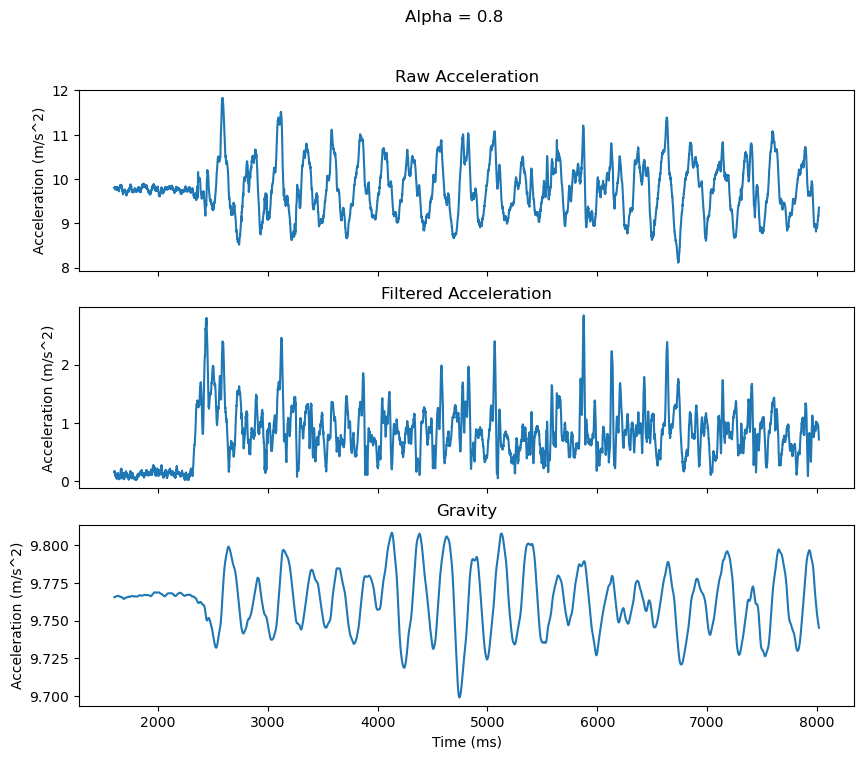

In [94]:
figure, axes = plt.subplots(3, 1, figsize=(10, 8), sharex=True)
figure.suptitle(f"Alpha = {alpha}")

raw_accel_df.iloc[win_len:].apply(lambda x: np.linalg.norm(x[1:4]), axis=1).plot(x="timestamp", y=["xa", "ya", "za"], xlabel="Time (ms)", ylabel="Acceleration (m/s^2)", title="Raw Acceleration", ax=axes[0])
imu_df.iloc[win_len:].apply(lambda x: np.linalg.norm(x[1:4]), axis=1).plot(x="timestamp", y=["xa", "ya", "za"], xlabel="Time (ms)", ylabel="Acceleration (m/s^2)", title="Filtered Acceleration", ax=axes[1])
accel_mavg.iloc[win_len:].apply(lambda x: np.linalg.norm(x[:3]), axis=1).plot(x="timestamp", y=["x", "y", "z"], xlabel="Time (ms)", ylabel="Acceleration (m/s^2)", title="Gravity", ax=axes[2])

<AxesSubplot:title={'center':'Filtered Acceleration'}, xlabel='Time (ms)', ylabel='Acceleration (m/s^2)'>

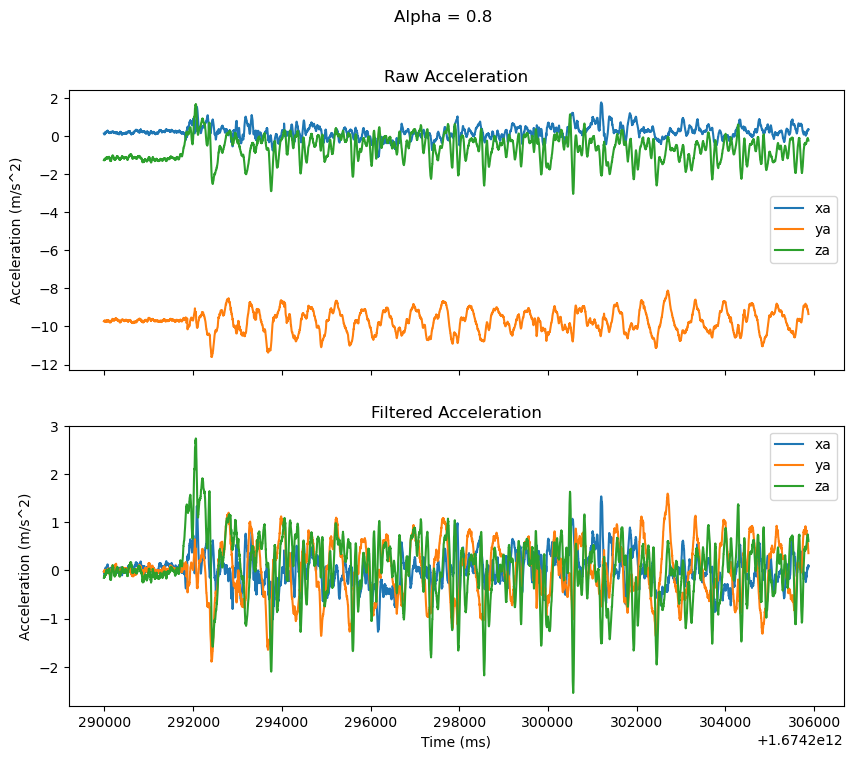

In [95]:
figure, axes = plt.subplots(2, 1, figsize=(10, 8), sharex=True)
figure.suptitle(f"Alpha = {alpha}")
raw_accel_df.iloc[win_len:].plot(x="timestamp", y=["xa", "ya", "za"], xlabel="Time (ms)", ylabel="Acceleration (m/s^2)", title="Raw Acceleration", ax=axes[0])
imu_df.iloc[win_len:].plot(x="timestamp", y=["xa", "ya", "za"], xlabel="Time (ms)", ylabel="Acceleration (m/s^2)", title="Filtered Acceleration", ax=axes[1])

In [96]:
# remove nan values due to rolling mean
imu_df = imu_df.iloc[win_len:]
# compute dt in seconds
imu_df.loc[:, "dt"] = np.concatenate([[0], (imu_df.timestamp.values[1:] - imu_df.timestamp.values[:-1]) / 1000])
# remove first row as the dt is 0
imu_df = imu_df.iloc[1:]
# reset index in pandas data frame
imu_df.reset_index(drop=True, inplace=True)

# Fill 0 for displacement, angles, and coordinates
imu_df.loc[:, "x"] = np.zeros(len(imu_df))
imu_df.loc[:, "y"] = np.zeros(len(imu_df))
imu_df.loc[:, "z"] = np.zeros(len(imu_df))

In [97]:
# calculate displacement and rotation
rotation_matrix = np.identity(4)

velocity = [0, 0, 0]

for i in tqdm.tqdm(range(1, len(imu_df))):
    v = imu_df.iloc[i].values
    dt = v[7]
    # current displacement and rotation
    da = np.degrees([v[j + 4] * dt for j in range(3)])
    dd = [(velocity[j] * dt) + (0.5 * v[j + 1] * dt * dt) for j in range(3)]
    
    d = np.dot(rotation_matrix, np.array([*dd, 1]))
    
    imu_df.iloc[i, 8] = imu_df.iloc[i - 1, 8] + d[0]
    imu_df.iloc[i, 9] = imu_df.iloc[i - 1, 9] + d[1]
    imu_df.iloc[i, 10] = imu_df.iloc[i - 1, 10] + d[2]
    
    rotation_matrix = helpers.rotate_transformation_matrix(rotation_matrix, da[0], da[1], da[2])
    velocity = [velocity[j] + v[j + 1] * dt for j in range(3)]

100%|██████████| 6414/6414 [00:02<00:00, 3022.02it/s]


In [98]:
# create trajectory as a pcd
xyz = imu_df.loc[:, ["x", "y", "z"]].values
pcd = helpers.make_pcd(xyz)
pcd.paint_uniform_color([1, 0, 0])

# load ground truth trajectory
sequence_ts = fread.get_timstamps_from_images(os.path.join(data_dir, experiment, trial, subject, f"{sequence:02d}", "frames"), ext=".depth.png")
start_t = helpers.nearest(sequence_ts, imu_df.timestamp.values[0])
start_index = np.where(sequence_ts == start_t)[0][0]

trajectory_t = np.load(pose_file)["trajectory_t"]
pcd_gt = helpers.make_pcd(trajectory_t[start_index:, :3, 3])
pcd_gt.paint_uniform_color([0, 1, 0])
    
print("IMU Distance: ", np.linalg.norm(xyz[-1] - xyz[0]))
print("GT Distance: ", np.linalg.norm(trajectory_t[-1, :3, 3] - trajectory_t[start_index, :3, 3]))

IMU Distance:  11.454788621944491
GT Distance:  10.158485928655006


In [99]:
open3d.visualization.draw_geometries([pcd, pcd_gt])

### Orientation tracking

In [57]:
win_len = int(frame_rate * 3) # 3 seconds window

gravity = imu_df.iloc[:win_len, [1, 2, 3]].mean().values

In [58]:
imu_df = imu_df.iloc[win_len:]
# compute dt in seconds
imu_df.loc[:, "dt"] = np.concatenate([[0], (imu_df.timestamp.values[1:] - imu_df.timestamp.values[:-1]) / 1000])
# remove first row as the dt is 0
imu_df = imu_df.iloc[1:]
# reset index in pandas data frame
imu_df.reset_index(drop=True, inplace=True)

# Fill 0 for displacement, angles, and coordinates
imu_df.loc[:, "x"] = np.zeros(len(imu_df))
imu_df.loc[:, "y"] = np.zeros(len(imu_df))
imu_df.loc[:, "z"] = np.zeros(len(imu_df))

In [59]:
accel_df = pd.DataFrame(columns=["timestamp", "x", "y", "z"])

In [60]:
# calculate displacement and rotation
rotation_matrix = np.identity(4)

velocity = [0, 0, 0]

for i in tqdm.tqdm(range(1, len(imu_df))):
    v = imu_df.iloc[i].values
    
    dt = v[7]
    # current displacement and rotation
    da = np.degrees([v[j + 4] * dt for j in range(3)])
    
    acceleration = imu_df.iloc[i, [1, 2, 3]].values
    acceleration = np.dot(rotation_matrix, np.array([*acceleration, 1]))
    acceleration = acceleration[:3] - gravity
    
    accel_df = pd.concat([accel_df, pd.DataFrame([[v[0], *acceleration]], columns=["timestamp", "x", "y", "z"])])
    
    d = [(velocity[j] * dt) + (0.5 * acceleration[j] * dt * dt) for j in range(3)]
    
    # d = np.dot(rotation_matrix, np.array([*dd, 1]))
    
    imu_df.iloc[i, 8] = imu_df.iloc[i - 1, 8] + d[0]
    imu_df.iloc[i, 9] = imu_df.iloc[i - 1, 9] + d[1]
    imu_df.iloc[i, 10] = imu_df.iloc[i - 1, 10] + d[2]
    
    rotation_matrix = helpers.rotate_transformation_matrix(rotation_matrix, da[0], da[1], da[2])
    
    velocity = [velocity[j] + acceleration[j] * dt for j in range(3)]

100%|██████████| 6815/6815 [00:10<00:00, 679.86it/s]


In [61]:
accel_df.reset_index(drop=True, inplace=True)

Text(0, 0.5, 'Acceleration (m/s^2)')

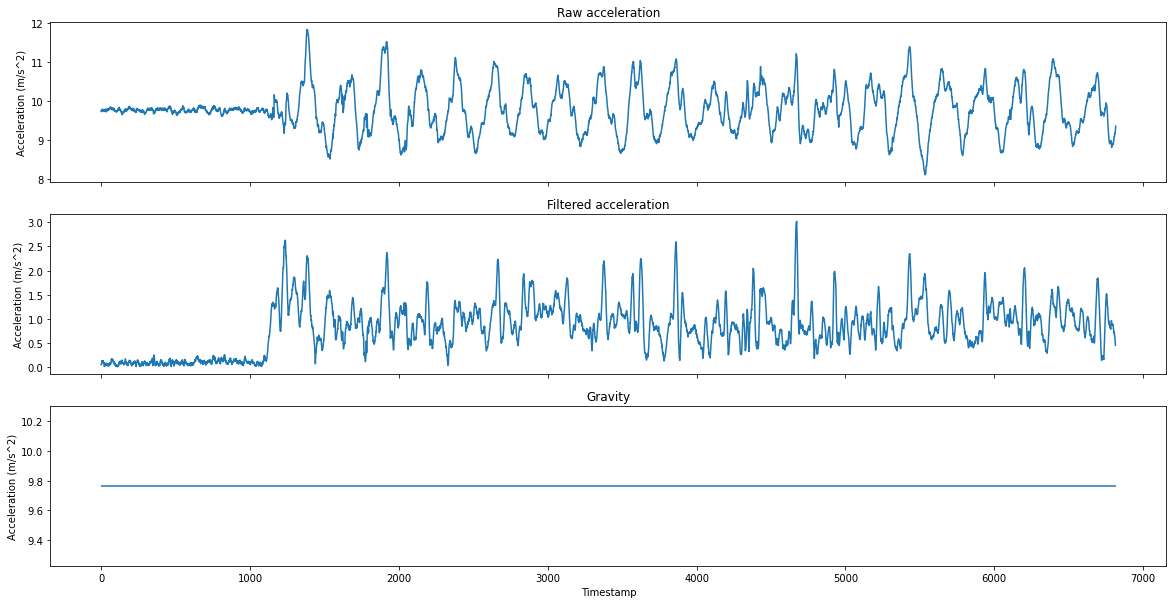

In [63]:
figure, axes = plt.subplots(3, 1, figsize=(20, 10), sharex=True)

raw_accel_df.iloc[win_len:].apply(lambda x: np.linalg.norm(x[1:4]), axis=1).reset_index(drop=True).plot(xlabel="Timestamp", ylabel="Acceleration (m/s^2)", title="Raw acceleration", ax=axes[0])
accel_df.apply(lambda x: np.linalg.norm(x[1:4]), axis=1).plot(xlabel="Timestamp", ylabel="Acceleration (m/s^2)", title="Filtered acceleration", ax=axes[1])
axes[2].hlines(np.linalg.norm(gravity), 0, len(accel_df))
axes[2].set_title("Gravity")
axes[2].set_xlabel("Timestamp")
axes[2].set_ylabel("Acceleration (m/s^2)")


In [49]:
# create trajectory as a pcd
xyz = imu_df.loc[:, ["x", "y", "z"]].values
pcd = helpers.make_pcd(xyz)
pcd.paint_uniform_color([1, 0, 0])

# load ground truth trajectory
sequence_ts = fread.get_timstamps_from_images(os.path.join(data_dir, experiment, trial, subject, f"{sequence:02d}", "frames"), ext=".depth.png")
start_t = helpers.nearest(sequence_ts, imu_df.timestamp.values[0])
start_index = np.where(sequence_ts == start_t)[0][0]

trajectory_t = np.load(pose_file)["trajectory_t"]
pcd_gt = helpers.make_pcd(trajectory_t[start_index:, :3, 3])
pcd_gt.paint_uniform_color([0, 1, 0])
    
print("IMU Distance: ", np.linalg.norm(xyz[-1] - xyz[0]))
print("GT Distance: ", np.linalg.norm(trajectory_t[-1, :3, 3] - trajectory_t[start_index, :3, 3]))

IMU Distance:  17.64110494917146
GT Distance:  10.17501507322044


In [50]:
open3d.visualization.draw_geometries([pcd, pcd_gt])

Experiment to check integration with simulated data

In [78]:
imu = [[2] for _ in range(2000)] + [[0] for _ in range(3000)] + [[-2] for _ in range(2000)]
timestamps = [[i] for i in range(7000)]

data = np.concatenate([timestamps, imu], axis=1)

accel_df = pd.DataFrame(data, columns=["timestamp", "x"])

In [79]:
# accel_df.loc[:, "dt"] = (accel_df.timestamp.values - accel_df.timestamp.values[0]) / 1000
accel_df.loc[:, "dt"] = np.concatenate([[0], (accel_df.timestamp.values[1:] - accel_df.timestamp.values[:-1]) / 1000])
# remove first row
accel_df = accel_df.iloc[1:]

In [80]:
accel_df.loc[:, "dx"] = np.zeros(len(accel_df))

In [76]:
accel_df.values[10]

array([1.2e+01, 2.0e+00, 1.0e-03])

In [84]:
velocity = 0
distance = 0

for i in tqdm.trange(len(accel_df)):
    v = accel_df.iloc[i].values
    dt = v[2]
    distance = distance + (velocity * dt) + (0.5 * v[1] * dt * dt)
    accel_df.iloc[i, 3] = distance
    velocity = velocity + v[1] * dt

100%|██████████| 6999/6999 [00:01<00:00, 5301.51it/s]


<AxesSubplot:xlabel='timestamp'>

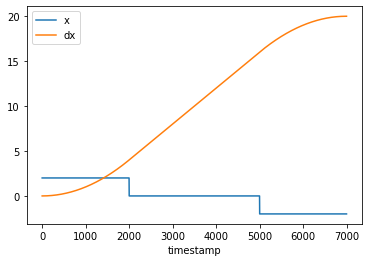

In [85]:
accel_df.set_index("timestamp").loc[:, ["x", "dx"]].plot()

In [ ]:
d = 0.5 * 2 * 4 + 4 * 3 + 0.5 * 4 * 2
print(f"Total distance: {d}")

Linear acceleration from Android API

In [105]:
accel_df = pd.read_csv("data/android/1673931013121/acceleration.csv", names=["timestamp", "x", "y", "z"])
gyro_df = pd.read_csv("data/android/1673931013121/gyroscope.csv", names=["timestamp", "x", "y", "z"])

In [106]:
accel_df.drop_duplicates("timestamp", inplace=True)
gyro_df.drop_duplicates("timestamp", inplace=True)

<AxesSubplot:xlabel='timestamp'>

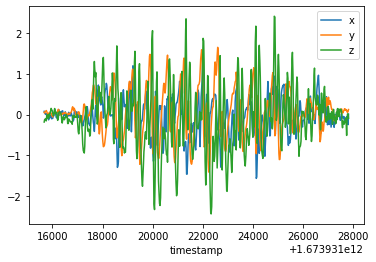

In [107]:
accel_df.loc[125:, ["timestamp", "x", "y", "z"]].set_index("timestamp").plot()

In [108]:
accel_df = accel_df.iloc[125:]

accel_df.loc[:, "gyro_t"] = accel_df.apply(lambda x: nearest(gyro_df.timestamp.values, x.timestamp), axis=1)

imu_df = pd.merge(
    accel_df.loc[:, ["gyro_t", "x", "y", "z"]],
    gyro_df.loc[:, ["timestamp", "x", "y", "z"]],
    left_on="gyro_t",
    right_on="timestamp",
    suffixes=("a", "g")
)

imu_df.drop("gyro_t", axis=1, inplace=True)
imu_df = imu_df.loc[:, ["timestamp", "xa", "ya", "za", "xg", "yg", "zg"]]

In [109]:
# remove first second's data (as it stabilizes the gravity)
# imu_df = imu_df.iloc[400:]
# compute dt in seconds
imu_df.loc[:, "dt"] = np.concatenate([[0], (imu_df.timestamp.values[1:] - imu_df.timestamp.values[:-1]) / 1000])
# remove first row as the dt is 0
imu_df = imu_df.iloc[1:]
# reset index in pandas data frame
imu_df.reset_index(drop=True, inplace=True)

In [110]:
# Fill 0 for displacement and angles
imu_df.loc[:, "dx"] = np.zeros(len(imu_df))
imu_df.loc[:, "dy"] = np.zeros(len(imu_df))
imu_df.loc[:, "dz"] = np.zeros(len(imu_df))
imu_df.loc[:, "rx"] = np.zeros(len(imu_df))
imu_df.loc[:, "ry"] = np.zeros(len(imu_df))
imu_df.loc[:, "rz"] = np.zeros(len(imu_df))

In [111]:
# displacement = [0, 0, 0]
velocity = [0, 0, 0]
angle = [0, 0, 0]

for i in range(len(imu_df)):
    imu = imu_df.iloc[i].values
    dt = imu[7]
    for j, axis in enumerate(["x", "y", "z"]):
        # velocity[j] = velocity[j] + imu[j + 1] * dt
        # Update the displacement
        # displacement[j] = displacement[j] + (velocity[j] * dt) + (0.5 * acceleration[j + 1] * dt * dt)
        angle[j] += imu[j + 4] * dt

        imu_df.iloc[i, 8 + j] = (velocity[j] * dt) + (0.5 * imu[j + 1] * dt * dt)
        # imu_df.iloc[i, 11 + j] = imu[j + 4] * dt
        imu_df.iloc[i, 11 + j] = np.degrees(angle[j])

        velocity[j] = velocity[j] + imu[j + 1] * dt

In [112]:
imu_df.loc[:, "x"] = np.zeros(len(imu_df))
imu_df.loc[:, "y"] = np.zeros(len(imu_df))
imu_df.loc[:, "z"] = np.zeros(len(imu_df))

In [113]:
for i in range(1, len(imu_df)):
    c = imu_df.iloc[i].values           # current readings
    p = imu_df.iloc[i - 1].values       # previous readings

    R = helpers.rotate_transformation_matrix(np.identity(4), p[11], p[12], p[13])

    d = np.dot(R, np.array([c[8], c[9], c[10], 1]))

    imu_df.iloc[i, 14] = p[14] + d[0]
    imu_df.iloc[i, 15] = p[15] + d[1]
    imu_df.iloc[i, 16] = p[16] + d[2]

In [114]:
xyz = imu_df.loc[:, ["x", "y", "z"]].values

pcd = open3d.geometry.PointCloud()
pcd.points = open3d.utility.Vector3dVector(xyz)

open3d.visualization.draw_geometries([pcd])

In [115]:
np.linalg.norm(xyz[-1])

8.289169564567784